# Генерация имен с помощью реккурентной НС

In [1]:
# Uncomment this cell in Colab


! wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names -O names

--2025-08-19 07:44:17--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.009s  

2025-08-19 07:44:17 (5.81 MB/s) - ‘names’ saved [55868/55868]



In [61]:
start_token = "<"
last_token = ">"
pad_token = "_"


names = []

with open('names') as f:
  for name in f.readlines():
    names.append(start_token + name.strip()+ last_token)


In [62]:
print(f"N samples: {len(names)}")
names[::1000]

N samples: 7944


['<Abagael>',
 '<Claresta>',
 '<Glory>',
 '<Liliane>',
 '<Prissie>',
 '<Geeta>',
 '<Giovanne>',
 '<Piggy>']

Max length is 17


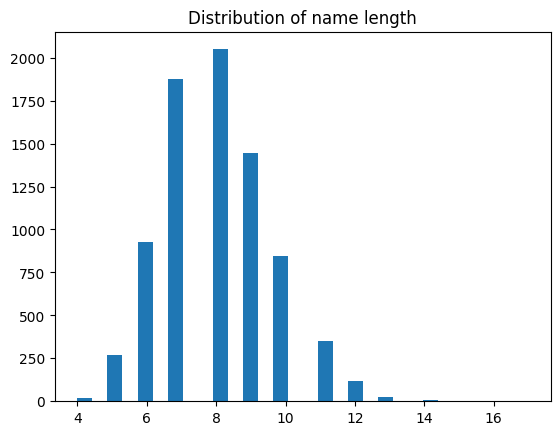

In [63]:
import matplotlib.pyplot as plt

MAX_LENGTH = max(map(len, names))
print(f"Max length is {MAX_LENGTH}")

plt.hist(list(map(len, names)),bins = 30)
plt.title('Distribution of name length')
plt.show()

In [64]:
tokens = set()
for name in names:
  tokens.update(set(name))

tokens.add(pad_token)

num_tokens = len(tokens)
print(f"Number of tokens is {num_tokens}")

assert (
    50 < num_tokens < 60
), "Names should contain within 50 and 60 unique tokens depending on encoding"

Number of tokens is 58


In [65]:
id_to_tokens= list(tokens)
tokens_to_id = {token : idx for idx, token in enumerate(id_to_tokens, start = 0)}

In [66]:
for i in range(len(id_to_tokens)):
  assert(
      tokens_to_id[id_to_tokens[i]] == i,
  ) , "Incorrect initialise id_to_tokens and tokens_to_id"
print('Everything good')

Everything good


<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipython-input-4285725162.py:2: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(


In [95]:
import numpy as np

def to_matrix(
    names_batch,
    max_len=None,
    pad=tokens_to_id[pad_token],
    dtype="int32",
    batch_first=False,
):

    max_len = max_len or max(map(len, names_batch))
    names_ix = np.zeros([len(names_batch), max_len], dtype) + pad

    for i in range(len(names_batch)):
        line_ix = [tokens_to_id[c] for c in names_batch[i]][:max_len]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:
        names_ix = np.transpose(names_ix)

    return names_ix


In [96]:
print('Batch of names')
print(names[::2000])
print("Matrix batch")
print(to_matrix(names[::2000]).T)

Batch of names
['<Abagael>', '<Glory>', '<Prissie>', '<Giovanne>']
Matrix batch
[[31 40 32  4 52  4 42 13 29  8]
 [31 15 13 49 12 35 29  8  8  8]
 [31 27 12 50 51 51 50 42 29  8]
 [31 15 50 49 48  4 22 22 42 29]]


In [97]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [98]:
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
      x_emb = self.embedding(x)

      state = torch.cat([x_emb, h_prev],dim = -1)


      x_and_h = torch.cat([x_emb, h_prev], dim=-1)
      h_next = self.rnn_update(x_and_h)

      h_next = torch.tanh(h_next)

      assert h_next.size() == h_prev.size()


      logits = self.rnn_to_logits(h_next)

      return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [99]:
rnnModel = CharRNNCell()

In [100]:
def rnn_loop(char_rnn, batch_ix):

    max_length, batch_size = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = char_rnn(
            x_t, hid_state
        )
        all_logits.append(logits_next)

    return torch.stack(all_logits, dim=1)

In [101]:
from IPython.display import clear_output
from random import sample
import tqdm

In [104]:
def train(model, loss_func, iter = 1000 ,optim = torch.optim.Adam , MAX_LENGTH = 16):
  history = []
  opt = optim(model.parameters())

  for i in tqdm.tqdm(range(iter)):
    opt.zero_grad()
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    all_logits = rnn_loop(model, batch_ix)

    actual_next_tokens = batch_ix[1:, :].T

    pred_logits = all_logits[:, :-1, :]
    pred_logits_flattened = pred_logits.reshape(
        (pred_logits.shape[0] * pred_logits.shape[1], -1)
    )
    actual_next_tokens_flattened = actual_next_tokens.reshape(-1)
    loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)

    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

  assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."



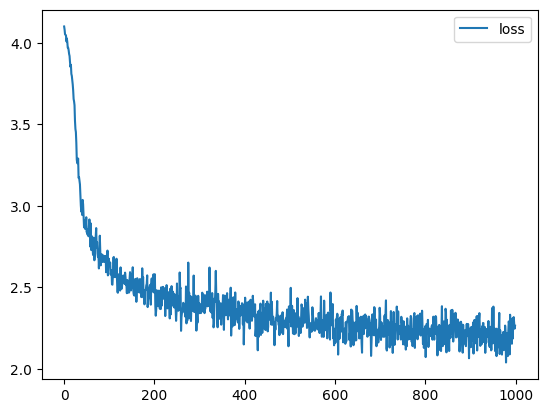

100%|██████████| 1000/1000 [00:06<00:00, 162.33it/s]


In [105]:
loss_func = nn.CrossEntropyLoss(ignore_index=tokens_to_id[pad_token])

train(rnnModel, loss_func)

In [125]:
def pretty_word(word):
  return word.replace('<', '').split('>')[0]


def generate_name(model, start_phrase = "<" , max_length = 16,  temperature=1.0, pretty = True):

  x_seq = [tokens_to_id[c] for c in start_phrase]
  x_seq = torch.tensor([x_seq], dtype=torch.int64)
  hid_state = model.initial_state(batch_size = 1)

  #feed
  for _ in range(len(x_seq) -1):
    hid_state, _ = model(x_seq[:, i], hid_state)

  for i in range(max_length - len(x_seq)):
    hid_state, logit = model(x_seq[:,-1], hid_state)
    p_next = F.softmax(logit / temperature, dim = -1).data.numpy()[0]

    next_ix = np.random.choice(num_tokens, p=p_next)
    next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
    x_seq = torch.cat([x_seq, next_ix], dim=1)

  output = "".join([id_to_tokens[idx] for idx in x_seq.data.numpy()[0]])

  if pretty:
    return pretty_word(output)
  return output



Пример генерации (с начального символа '<')

In [126]:
for _ in range(10):
  print(generate_name(rnnModel))

Lylvaan
Brina
Kari
Lionaak
Edenna
Laona
Delli
Baudey
Batwie
Manise


Пример генерации начиная с "Al" и темпиратурой 1.5

In [127]:
for _ in range(10):
  print(generate_name(rnnModel, start_phrase="Al", temperature=1.5))

AlJhuei
Alukher
AlYhaydirpy
Aliavore-DoOnes
Almylse
Alhzemioma
AlFShiri
AlUny
AlTo
AlGice
